# Intercomparison Campaigns

**Contains modified Copernicus Climate Change Service Information 2020**
under [License](https://apps.ecmwf.int/datasets/licences/copernicus/)

*Copernicus Climate Change Service (C3S) - Upper Air Data Service (2020)*

The purpose of this IPython Notebook is to demonstrate the access and usability of data from intercomparison campaigns. Example usage of the Climate Data Store (CDS) Frontend for Radiosonde data.

    Author: M. Blaschek
    Date: 09.2020
    Contact: michael.blaschek [at] univie.ac.at
    License: C3S, 2020


In [1]:
# %pylab inline

In [16]:
import pandas
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
import cdsapi, zipfile, os, time
import urllib3
urllib3.disable_warnings(urllib3.exceptions.InsecureRequestWarning) # just cosmetics

# Please note: Server URL will be omitted, once published
c = cdsapi.Client(url='https://sis-dev.climate.copernicus.eu/api/v2')

## Request soundings from an intercomparison campaign

We choose the following intercomparison campaign:

    WMO International radiosonde comparison, Tsukuba, Japan, 15.Feb to 12. Mar. 1993

    INSTRUMENTS and OBSERVING METHODS REPORT No. 59

The request for the intercomparison data looks exactly the same as for all the other data requests. In order to retrieve the data station IDs need to be given:
* `0-20100-0-01802`, Type: `VHN` ( Vaisala RS80-15N or RS80-15NA radiosonde )
* `0-20100-0-01803`, Type: `VHl` ( Vaisala RS80-15LH H-Humicap LoRAN radiosonde )
* `0-20100-0-01804`, Type: `J8H` ( Japan Meisei RSII-80 or RS2-80 high-resolution radiosonde )
* `0-20100-0-01805`, Type: `J93` ( Japan Meisei RSII-91 radiosonde, SiO type 93 uncoated thermistor )

We request a csv file and read the data with `pandas`.

In [18]:
t0 = time.time()
# Start Request
r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
               {
                   'variable': ["air_temperature"],
                   'statid': ['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805'],
                   'format': 'csv'                   
               })

if True:
    # Start Download
    r.download(target='download.zip')
    # Check file size
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    # Unzip the Data Stream
    z = zipfile.ZipFile('download.zip')
    print("Unzipping retrieved files: to ./exampla_data/1")
    print(z.namelist())
    z.extractall(path='./example_data/1')
    z.close()
    os.remove('download.zip')
    print("Time elapsed: ", time.time()-t0, "s")

2020-09-10 15:23:03,477 INFO Welcome to the CDS
2020-09-10 15:23:03,477 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network
2020-09-10 15:23:03,915 INFO Request is completed
2020-09-10 15:23:03,916 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1599737705.7595785-26515-8-f6594316-6cca-4cae-8ad6-d07f8a7117af.zip to download.zip (270.6K)
2020-09-10 15:23:04,120 INFO Download rate 1.3M/s 


Unzipping retrieved files: to ./exampla_data/1
['temperature.csv']
Time elapsed:  0.8136487007141113 s


---
## Read data

In [23]:
import pandas as pd
pd.set_option('display.width',200, 'display.max_rows',50)
data = pd.read_csv('example_data/1/temperature.csv', index_col=0)
sondestypes = dict(zip(['0-20100-0-01802','0-20100-0-01803', '0-20100-0-01804', '0-20100-0-01805'],['VHN', 'VHl', 'J8H', 'J93']))

In [24]:
print(data)

          lat     lon      plev      ta                 time     trajectory_label           statid  statindex
obs_id                                                                                                       
0       36.05  140.13    2900.0  216.75  1993-02-18 01:09:40  0-20100-0-01802-001  0-20100-0-01802          0
1       36.05  140.13    3010.0  215.65  1993-02-18 01:08:40  0-20100-0-01802-001  0-20100-0-01802          0
2       36.05  140.13    3170.0  216.75  1993-02-18 01:07:40  0-20100-0-01802-001  0-20100-0-01802          0
3       36.05  140.13    3300.0  216.45  1993-02-18 01:06:40  0-20100-0-01802-001  0-20100-0-01802          0
4       36.05  140.13    3440.0  216.45  1993-02-18 01:05:40  0-20100-0-01802-001  0-20100-0-01802          0
...       ...     ...       ...     ...                  ...                  ...              ...        ...
23112   36.05  140.13   90040.0  273.75  1993-03-11 11:34:21  0-20100-0-01805-060  0-20100-0-01805          3
23113   36

### Observation Periods (IOP) for the intercomparison campaign

In [21]:
# Every Row is an IOP
with pd.option_context('display.max_rows',None):
    print(data.groupby(data['trajectory_label'].str.split('-', expand=True)[4]).count())

     lat  lon  plev   ta  time  trajectory_label  statid  statindex
4                                                                  
001  463  463   463  463   463               463     463        463
002  322  322   322  322   322               322     322        322
003  285  285   285  285   285               285     285        285
004  194  194   194  194   194               194     194        194
005  340  340   340  340   340               340     340        340
006  328  328   328  328   328               328     328        328
007  395  395   395  395   395               395     395        395
008  423  423   423  423   423               423     423        423
009  460  460   460  460   460               460     460        460
010  360  360   360  360   360               360     360        360
011  384  384   384  384   384               384     384        384
012  416  416   416  416   416               416     416        416
013  396  396   396  396   396               396

---
## IOP 002 - 17.Feb 1993

In [22]:
ascent = '-002'
#
# extract following data from each sensor of ascent #002:
# temperature, pressure and datetime
#
temperature = []
pressure = []
datetime = []
for i in data.statid.drop_duplicates():
    print('statid: ' + i)
    buffer = data[data.trajectory_label == i + ascent]
    print('trajectory_label: ' + i + ascent, '#', buffer.shape[0])
    temperature.append(np.array(buffer.ta))
    pressure.append(np.array(buffer.plev))
    datetime.append(np.array(buffer.time))
#    
# get the time into the right shape for later plotting:
# minutes after the ascent start
#
for j in range(len(datetime)):
    for i in range(len(datetime[j])):
        if(i == 0):
            datezero = pd.to_datetime(datetime[j][0])
        datetime[j][i] = (datezero - pd.to_datetime(datetime[j][i]))/np.timedelta64(1,'m')  # convert to minutes

statid: 0-20100-0-01802
trajectory_label: 0-20100-0-01802-002 # 81
statid: 0-20100-0-01803
trajectory_label: 0-20100-0-01803-002 # 81
statid: 0-20100-0-01804
trajectory_label: 0-20100-0-01804-002 # 79
statid: 0-20100-0-01805
trajectory_label: 0-20100-0-01805-002 # 81


---
### Plotting of the profiles

In [27]:
# plot settings:
#
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (16, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

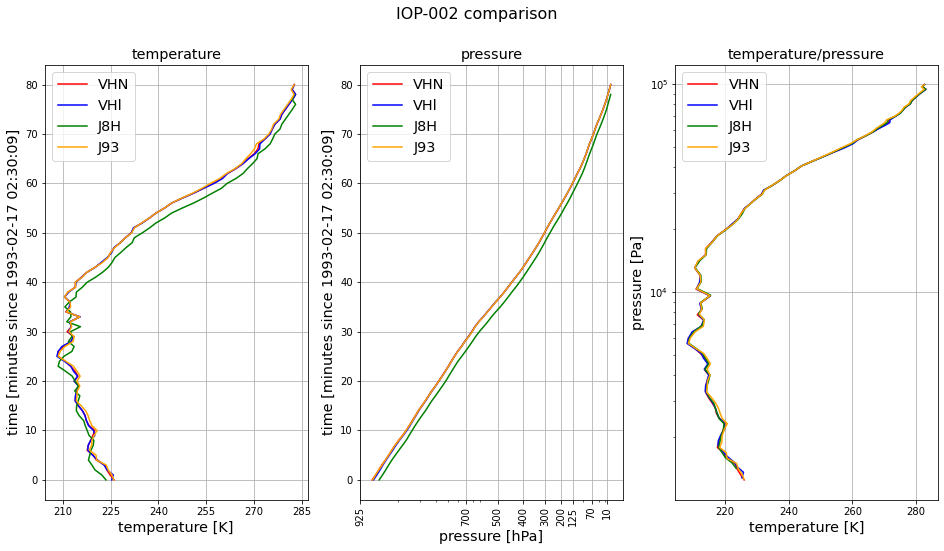

In [41]:
import matplotlib
import matplotlib.pyplot as plt
yplevs = np.array([10,70,125,200,300,400,500,700,925])*100.
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
#
# Plotting temperature over time:
#
ax1.plot(temperature[0], datetime[0], c='red')
ax1.plot(temperature[1], datetime[1], c='blue')
ax1.plot(temperature[2], datetime[2], c='green')
ax1.plot(temperature[3], datetime[3], c='orange')
ax1.set(xlabel='temperature [K]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='temperature')
#ax1.legend(data.statid.drop_duplicates(), loc='best')
ax1.legend(sondestypes.values(), loc='best')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.grid()
#
# Plotting pressure over time:
#
ax2.semilogx(pressure[0], datetime[0], c='red')
ax2.semilogx(pressure[1], datetime[1], c='blue')
ax2.semilogx(pressure[2], datetime[2], c='green')
ax2.semilogx(pressure[3], datetime[3], c='orange')
ax2.set(xlabel='pressure [hPa]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='pressure')
# ax2.legend(data.statid.drop_duplicates(), loc='best')
ax2.legend(sondestypes.values(), loc='best')
# ax2.xaxis.set_major_locator(plt.MaxNLocator(6))
ax2.set_xticks(ticks=yplevs)
ax2.set_xticklabels(map("{:.0f}".format,yplevs[::-1]/100),rotation='vertical')
ax2.grid()
#
# Plotting pressure over temperature:
#
ax3.semilogy(temperature[0], (pressure[0]), c='red')
ax3.semilogy(temperature[1], (pressure[1]), c='blue')
ax3.semilogy(temperature[2], (pressure[2]), c='green')
ax3.semilogy(temperature[3], (pressure[3]), c='orange')
ax3.set(xlabel ='temperature [K]', ylabel='pressure [Pa]', title='temperature/pressure')
# ax3.legend(data.statid.drop_duplicates(), loc='best')
ax3.legend(sondestypes.values(), loc='best')
ax3.grid()
#     -
fig.suptitle('IOP'+ascent+' comparison', fontsize=16)
plt.show()
plt.close(fig)

---
## Plot the pressure differences to the first sonde

In [8]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (8, 8),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

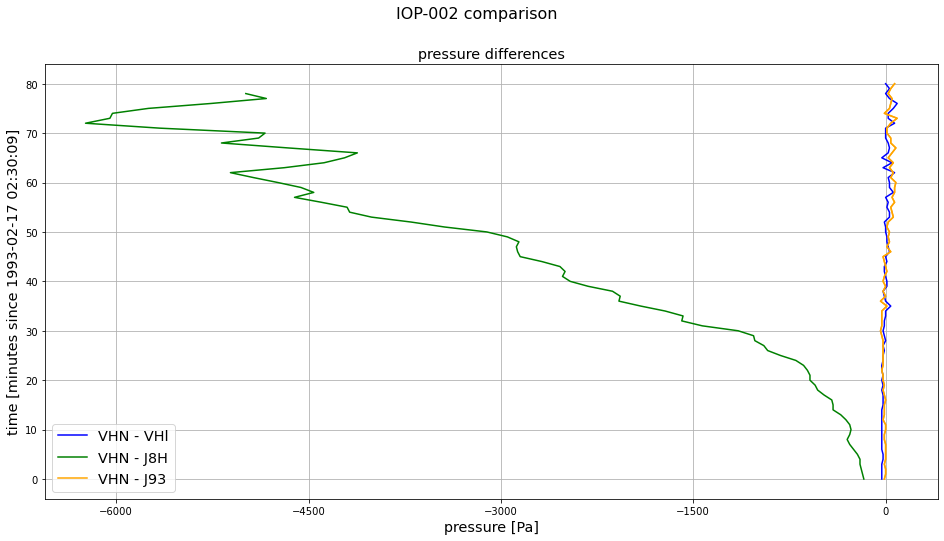

<Figure size 576x576 with 0 Axes>

In [48]:
fig, (ax1) = plt.subplots(1)
#
# Plotting pressur differences over time:
# pressure[0] is the longest data, so it will be shortened to the length of the comparison counterpart
#
ax1.plot(pressure[0][:len(pressure[1])] - pressure[1], datetime[1][:len(pressure[1])], c='blue')
ax1.plot(pressure[0][:len(pressure[2])] - pressure[2], datetime[2][:len(pressure[2])], c='green')
ax1.plot(pressure[0][:len(pressure[3])] - pressure[3], datetime[3][:len(pressure[3])], c='orange')
ax1.plot(pressure[0] - pressure[3], datetime[0], c='orange')
ax1.set(xlabel='pressure [Pa]', ylabel ='time [minutes since ' + np.min(buffer.time) + ']', title='pressure differences')
['VHN', 'VHl', 'J8H', 'J93']
ax1.legend(['VHN - VHl', 'VHN - J8H', 'VHN - J93'], loc='best')
ax1.xaxis.set_major_locator(plt.MaxNLocator(6))
ax1.grid()
#
fig.suptitle('IOP'+ascent+' comparison', fontsize=16)
plt.figure(figsize=(8, 8))
plt.show()
plt.close(fig)

## Interpolating pressure data for sonde comparison:

### Interpolate the sonde pressure from one reference sonde to all the other sonds:

There is no height information, so the interpolation hast do be done over the time data.

This is a viable solution since all sensors were mounted on the same weather balloon and were at the exact same height all the time.

In [10]:
import os
from scipy.interpolate import interp1d
import sys

In [11]:
# Easy interpolation with SciPy:
# forward interpolation pressure on time:
#
f = interp1d( np.log(np.array(pressure[0])), np.array(datetime[0]))

#
# for any number of pressure levels:
#
pressure_list = [75000., 50000., 25000.] # Pa
pres_delta = []
for j in range(len(pressure_list)):
    print('Time at '+str(pressure_list[j])+' Pa: ' + str(f(np.log(pressure_list[j]))))
    pres_delta.append([])
    for i in range(len(pressure)):
        #
        # backward interpolation time on pressure:
        #
        g = interp1d( np.array(datetime[i]), np.log(np.array(pressure[i])))
        print('measured pressure at this time - sonde '+str(i+1)+': ' + str(np.exp(float((g(f(np.log(pressure_list[j]))))))) + ' Pa')
        pres_delta[j].append(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))
        print('delta pressure sonde 1 - '+str(i+1)+': ' + str(pressure_list[j] - np.exp(float((g(f(np.log(pressure_list[j])))))))+ ' Pa')
    print('---')

Time at 75000.0 Pa: 71.10149344512143
measured pressure at this time - sonde 1: 74999.99999999996 Pa
delta pressure sonde 1 - 1: 4.3655745685100555e-11 Pa
measured pressure at this time - sonde 2: 74993.0995776619 Pa
delta pressure sonde 1 - 2: 6.9004223381052725 Pa
measured pressure at this time - sonde 3: 80717.34745272146 Pa
delta pressure sonde 1 - 3: -5717.347452721457 Pa
measured pressure at this time - sonde 4: 74987.04288654937 Pa
delta pressure sonde 1 - 4: 12.957113450625911 Pa
---
Time at 50000.0 Pa: 60.285290385734285
measured pressure at this time - sonde 1: 50000.00000000001 Pa
delta pressure sonde 1 - 1: -7.275957614183426e-12 Pa
measured pressure at this time - sonde 2: 49972.7558558601 Pa
delta pressure sonde 1 - 2: 27.244144139898708 Pa
measured pressure at this time - sonde 3: 54793.461312091626 Pa
delta pressure sonde 1 - 3: -4793.461312091626 Pa
measured pressure at this time - sonde 4: 49931.029023466115 Pa
delta pressure sonde 1 - 4: 68.97097653388482 Pa
---
Time

In [12]:
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (18, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'medium',
         'ytick.labelsize':'medium'}
pylab.rcParams.update(params)

[Text(0.5, 0, 'sensor'),
 Text(0, 0.5, 'pressure difference [Pa]'),
 Text(0.5, 1.0, '25000 Pa')]

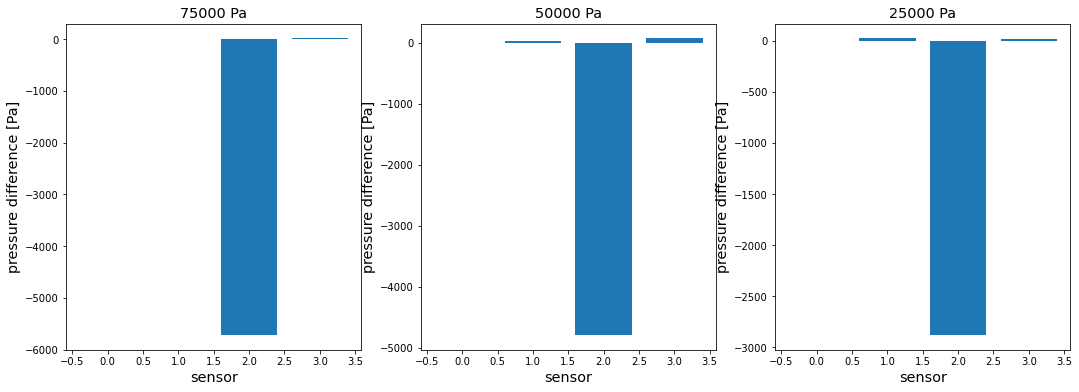

In [13]:
#
# create barplot for all the differences on different levels
#
np.arange(len(pres_delta))
#
fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
ax1.bar(np.arange(len(pres_delta[0])),(pres_delta[0]))
ax1.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='75000 Pa')
ax2.bar(np.arange(len(pres_delta[1])),(pres_delta[1]))
ax2.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='50000 Pa')
ax3.bar(np.arange(len(pres_delta[2])),(pres_delta[2]))
ax3.set(xlabel ='sensor', ylabel='pressure difference [Pa]', title='25000 Pa')
